# Entanglement Classifier Training Trial

## Importing Dependencies

In [49]:
import numpy as np
from sklearn.model_selection import train_test_split

from classifier.components.system import System
from classifier.components.interaction import InteractionFactory, Interaction
from classifier.components.model import Model
from classifier.components.interaction_functions import CascadeFunction, EnergyExchangeFunction, DampingFunction
from classifier.components.reservoir_analysis import ReservoirAnalyser

from quantum.core import GeneralQubitMatrixGen, DensityMatrix



## Constructing Reservoirs

### System Parameters

In [50]:
reservoir_nodes=[4]
system_nodes=2

### Setting up the interface

In [51]:
"""
Defining Interface setup
"""

interfaceFactory1 = InteractionFactory(CascadeFunction, gamma_1=1, gamma_2=1)
interfaceFactory2 = InteractionFactory(CascadeFunction, gamma_1=0, gamma_2=0)

### Setting up the reservoir

In [52]:
"""
Defining Reservoir setup
"""

reservoirFactory1 = InteractionFactory(EnergyExchangeFunction, coupling_strength=1)
reservoirFactory2 = InteractionFactory(DampingFunction, damping_strength=1)

### Setting up the model

In [53]:
reservoirs = []

for n_reservoir_nodes in reservoir_nodes:
    """
    Defining System setup
    """

    system_state = DensityMatrix(np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]))
    system_node_list = [0, 1]

    if len(system_node_list) != system_nodes:
        raise Exception

    system_interactions = {"sys_interaction_0" : Interaction(0, DampingFunction(0, n_reservoir_nodes+system_nodes, 1)),
                        "sys_interaction_1" : Interaction(1, DampingFunction(1, n_reservoir_nodes+system_nodes, 1))}

    system = System(
        init_quantum_state=system_state, nodes=system_node_list, interactions=system_interactions
    )



    model = Model()
    model.setSystem(system)
    model.setReservoirInteractionFacs(dualFactories=[reservoirFactory1], singleFactories=[reservoirFactory2])
    model.setInterfaceInteractionFacs([[interfaceFactory1, interfaceFactory2]])
    model.generateReservoir(n_reservoir_nodes, init_quantum_state=0, interaction_rate=.67)
    model.generateInterface(interaction_rate=.5)
    model.setRunDuration(1)
    model.setRunResolution(0.1)
    model.setSwitchStructureTime(2)

    reservoirs.append(model)

In [54]:
print(reservoirs[0].reservoir.singleInteractions.keys())

dict_keys(['res_interaction_0_2', 'res_interaction_0_3', 'res_interaction_0_4', 'res_interaction_0_5'])


In [55]:
analyser = ReservoirAnalyser(reservoirs)

In [56]:
import pickle

with open(f"/Users/matthewmackinnon/Documents/repos/entanglement_classifier_redesign/data/2_qubit_dataset.pkl", 'rb') as file:
            analyser.states = pickle.load(file)

In [57]:
import pickle

with open(f"/Users/matthewmackinnon/Documents/repos/entanglement_classifier_redesign/data/4_qubit_reservoir.pkl", 'rb') as file:
            analyser.datasets = [pickle.load(file)]

In [55]:
import cProfile

In [56]:
cProfile.run("reservoirs[0].transform(analyser.states[0])", sort="tottime")

         95410 function calls (95404 primitive calls) in 0.557 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1658    0.239    0.000    0.244    0.000 core.py:113(__mul__)
     1484    0.216    0.000    0.220    0.000 core.py:94(__mul__)
        5    0.010    0.002    0.010    0.002 attrsettr.py:65(_get_attr_opt)
     1340    0.009    0.000    0.012    0.000 core.py:28(__rmul__)
     5675    0.009    0.000    0.009    0.000 core.py:123(matrix)
      567    0.008    0.000    0.021    0.000 shape_base.py:1067(kron)
     1092    0.006    0.000    0.009    0.000 core.py:18(__add__)
      2/0    0.006    0.003    0.000          {method 'control' of 'select.kqueue' objects}
      560    0.005    0.000    0.211    0.000 core.py:85(commutator)
     1040    0.005    0.000    0.009    0.000 core.py:31(__sub__)
       22    0.005    0.000    0.006    0.000 linalg.py:1193(eig)
     2268    0.005    0.000    0.011    0.000 shape_b

analyser.generateStates(100000, n_qubits=system_nodes, state_subset="general")

In [57]:
analyser.transformStates(multiprocess=False)

Transforming reservoir 1


  0%|          | 37/100000 [00:14<10:51:18,  2.56it/s]

  0%|          | 364/100000 [02:24<11:00:08,  2.52it/s]


KeyboardInterrupt: 

with open(f'/Users/matthewmackinnon/Documents/repos/entanglement_classifier_redesign/data/4_qubit_reservoir.pkl', 'wb') as file:
        pickle.dump(analyser.datasets[0].transformed_states, file)

## Classical Processing

In [10]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [60]:
analyser.datasets

[[array([ 5.94191041e-02,  1.25788220e-18,  3.57329830e-02, -1.70998797e-18,
          3.28662102e-02, -2.49852350e-02, -3.85978607e-02,  2.11174925e-02,
         -6.53882626e-02, -5.43296010e-19,  3.28662102e-02, -2.49852350e-02,
         -6.31331641e-03, -9.95401780e-19,  1.90926870e-02, -2.49780344e-03,
         -1.09205650e-02, -2.87124621e-02, -3.85978607e-02,  2.11174925e-02,
         -6.53882626e-02, -2.49780344e-03, -1.09205650e-02, -2.87124621e-02,
          1.06007068e-01,  3.53019496e-02, -1.85207851e-02,  9.95401780e-19,
         -6.31331641e-03,  1.24929474e-02,  3.28662102e-02,  5.43296010e-19,
          8.32014800e-03,  2.11174925e-02, -1.67567308e-02, -3.47990275e-02,
          3.28662102e-02,  1.70998797e-18,  8.32014800e-03, -1.25788220e-18,
          5.94191041e-02, -3.74775227e-02, -1.09205650e-02,  3.97371816e-02,
         -5.74113390e-02,  2.11174925e-02, -1.67567308e-02, -3.47990275e-02,
         -1.09205650e-02,  3.97371816e-02, -5.74113390e-02,  3.53019496e-02,

In [61]:
dataset = analyser.datasets[0]

x = analyser.states
d = dataset
y = [state.negativity() for state in x]

x_train, x_test, y_train, y_test = train_test_split(d, y, test_size=0.1)

In [62]:
mlp = MLPRegressor().fit(np.real(x_train), y_train)
mlp.score(np.real(x_test), y_test)

0.5800856172506768

In [63]:
import matplotlib.pyplot as plt

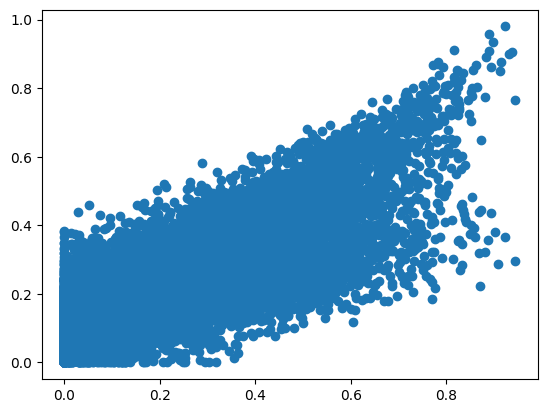

In [64]:
plt.scatter(y_test, [0 if pred < 0 else pred for pred in mlp.predict(x_test)])

In [ ]:
import pandas as pd

In [ ]:
import seaborn as sns

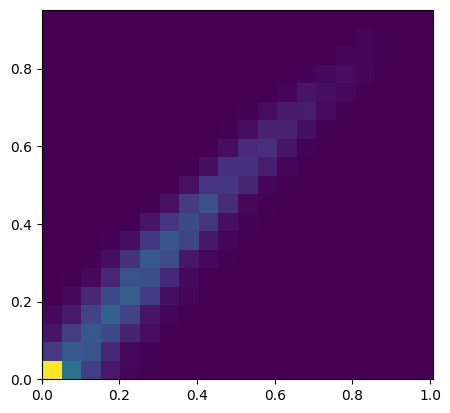

In [ ]:
heatmap, xedges, yedges = np.histogram2d([0 if pred < 0 else pred for pred in mlp.predict(x_test)], y_test, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [ ]:
np.array(y_test).shape

(10000,)

In [ ]:
np.array(y_test)[np.array(y_test) <= 0.8].shape

(9924,)

In [ ]:
pd.DataFrame(np.array([np.round(y_test, 2), np.round([0 if pred < 0 else pred for pred in mlp.predict(x_test)],2)]).T, columns=['Target', 'Prediction']).value_counts()

Target  Prediction
0.00    0.00          472
        0.01           69
        0.02           64
        0.03           56
        0.05           44
                     ... 
0.39    0.24            1
        0.46            1
        0.50            1
        0.52            1
0.95    0.91            1
Name: count, Length: 1931, dtype: int64

In [ ]:
np.round(y_test, 2)